### Packages

In [251]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as gg
from pathlib import Path
import umap.umap_ as umap
from scipy import stats
from functools import reduce
from sklearn.preprocessing import StandardScaler
import csv


In [252]:
# array([nan, 'ERK5', 'CDK14_pan-TAIRE', 'FAK', 'SECRET', 'PIN1', 'DCLK1',
#        'DMSO'], dtype=object)

In [253]:
cellline = "A549"

target = 'FAK'

controls = "DMSO"

target_list =[controls, target]
                               
variable_type='selected'

operation = 'mean'
value = 0.95  # 95th percentile

In [254]:
outpath = Path(os.path.join('../Figures', 'Features_map', str(cellline), str(target), 'Python'))

def makedirectory(path):
    if not os.path.exists(path):
        try:
            os.makedirs(path)  
            
        except OSError as error:
            print("directory already existed")
            
            
    return print("Directory created")
    
makedirectory(outpath)
outdirpath = outpath    
   


Directory created


## Loading data and wrangling

### Loading data

In [255]:

plates = ['BR00100032', 'BR00100037']


def csvpath():
    
    filepath = []
    
    for p in plates:
        path = os.path.join(Path('../', p))
    
        for f in os.listdir(path):
        
            if p + '.csv' in f:
                
                fpath = os.path.join(Path('../', p, f))
            
                filepath.append(fpath)
    
    return  filepath
    
def metadata_path():
    
    metapath = []
    
    for p in plates:
        path = os.path.join(Path('../', p))
    
        for f in os.listdir(path):
        
            if p + '_Metadata.csv' in f:
                
                fpath = os.path.join(Path('../', p, f))
            
                metapath.append(fpath)
    
    return  metapath  
 

selected_features = (np.loadtxt(Path(os.path.join('../metadata', 'featureslist.txt'))
                               , dtype='str')
                        .tolist()
                    )



csvpath = csvpath()[0]
metapath = metadata_path()[0]

df = pd.read_csv(csvpath)
meta_df = pd.read_csv(metapath)


df.head()

,Metadata_Plate,Metadata_Well,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0,Nuclei_Texture_Variance_RNA_5_0
0,BR00100032,A01,6778.000000,1028.421984,1043.838913,1.220096,0.696839,0.979364,0.571366,0.445670,...,3.688308,2.166273,2.019813,2.283675,2.074273,1.926354,2.216350,2.878437,2.631546,2.940671
1,BR00100032,A02,7719.637006,1053.346987,1032.415254,1.227962,0.700647,0.981403,0.570061,0.443659,...,3.725412,2.199962,2.057876,2.320029,2.131372,1.995233,2.261770,2.925393,2.702116,2.981096
2,BR00100032,A03,7496.007107,1047.747134,1062.363824,1.238884,0.705142,0.976616,0.565151,0.423226,...,3.520214,2.043512,1.932423,2.147437,1.993706,1.881165,2.108910,2.885900,2.662957,2.919533
3,BR00100032,A04,6906.156619,1063.926884,1041.044807,1.239696,0.708652,0.974949,0.564264,0.447692,...,3.764689,2.197547,2.068694,2.307226,2.130826,2.020131,2.251766,2.872209,2.628444,2.929586
4,BR00100032,A05,6371.250760,1080.395057,1046.627757,1.245503,0.708006,0.978517,0.565373,0.442762,...,3.506814,2.204440,2.088121,2.291974,2.077493,1.977993,2.181094,2.898165,2.630249,2.944957


### Data Preprocessing 

In [256]:

def preprocessing_normalization(data, metadata, variable_type, celline):
    
    """ data = dataframe
        metadata = metadata if seperate metadata dataframe to be merged
        variable_type = str object  options ('all', selected) 
        cellline = cellline
        datapreprocessing incase of variable_type='all' used, throwing
        brightfield and location features
        
        
        """

    brightfield_features = df.columns[df.columns.str.contains("Brightfield|Children|Center_X|Center_Y|_Number_Object_Number|Parent|Location")]


    variables_left = sorted(list(set(df.columns) - set(brightfield_features)))



    """ Saving a list in txt format"""

    # f = open("featureslist.txt", "w")

    # f.writelines(v + '\v' for v in variables_left)


    data = df.loc[:, variables_left]




## Merging metadata columns

    data = meta_df.merge(data, how='inner', on=['Metadata_Plate', 'Metadata_Well'])

    all_features = [col for col in data.columns if not "Metadata" in col]
    meta = [col for col in data.columns if  "Metadata" in col]
    
## Since we have 272 DMSO wells in total we used 112 sampling of DMSO wells to normalize data 
## in past using R. indorder to recapitulate results we have choosen same DMSO wells or standardization of data

    dmso_wells =["M03","A14","M19","G02", "O05","O20","P23", "J14" ,"D18", "D19","P08","M21",
                "P15","I01","B02","A07","L11", "P11","P06","N11","K15","D06","D09","B19","E14",
                "G01", "D04","I14","B08","O10","F10","P09","P07","L10","D02","A23", "J23","M12","C05","H23",
                "O19","O12","N24","K24","N17","B10","N21","C21","C24","O22","C15","I12","N10",
                "E01","P12","P17","B14","A21","N07","B17","L23","P16","C12","A16","F24",
                "D22","A06","M24","D14","N04","B15","K10","P21","C02","O03","A04","A13",
                "O01","H01","O04","C04","A22","D17","K11","B01","B11","L02","F13","B06","I11",
                "N01","G12","F11","K02","C16","I13","C19","J12","G13","D07","D13","K23",
                "H24","C03","O14","E24","E02","M10","M18","A17","B22","C06"]

    if variable_type == 'selected':
    
    # ## Z normalization of the features
    
        dmso = data[data['Metadata_Well'].isin(dmso_wells)][selected_features].values
    
        scaler = StandardScaler()
    
        data_std = scaler.fit(dmso).transform(data[selected_features].values)
    
        data_std = meta_df.merge(pd.DataFrame(data_std, columns=selected_features),
                         how='left',
                         left_index=True, 
                         right_index=True)
    
    elif variable_type == 'all':
    
        dmso = data[data['Metadata_Well'].isin(dmso_wells)][all_features].values
        # ## Z normalization of the features
    
        scaler = StandardScaler()
    
        data_std = scaler.fit(dmso).transform(data[all_features].values)
    
        data_std = meta_df.merge(pd.DataFrame(data_std, columns=all_features),
                         how='left',
                         left_index=True, 
                         right_index=True)
    
    

    data_std.loc[data_std['Metadata_compound_name'] == 'DMSO', 'Metadata_Target'] = 'DMSO'
    data_std.replace('CDK14 / pan-TAIRE','CDK14_pan-TAIRE', inplace=True)



    
    return data_std


    
data_std = preprocessing_normalization(df, meta_df, variable_type, cellline)
data_std.Metadata_compound_name.unique()




array(['DMSO', 'FMF-03-146-1', 'BJP-06-115-3', 'BJP-06-005-3', 'C4',
       'FMF-04-112-1', 'JWG-071', 'PND-1186', 'C3', 'FMF-04-159-2',
       'AX15836', 'BSJ-04-030', 'C2', 'FMF-05-176-1', 'JWG-119',
       'BSJ-03-136', 'C1'], dtype=object)

## Assigning Features groups, channels and calculating mean z-scores

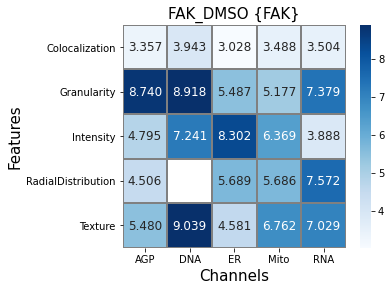

In [257]:

def All_feature_grid(df, cellline, target_list, comparison, operation):
    
   
    
     ## Selecting dataframe for specific cellline and samples
        
    d = df.query('Metadata_cell_line in @ cellline and Metadata_Target in @ target_list')



    feat = [col for col in d.columns if not "Metadata" in col]

    featlist =  ['Metadata_compound_name'] + feat



    dn = (d.loc[:, featlist].groupby('Metadata_compound_name')
      .mean()
      .T
      .reset_index()
      .rename(columns={'index': "variables"})
     )


    dn['Compartment'] = np.where(dn.variables.str.contains("Cells"), 'Cells',
                np.where(dn.variables.str.contains("Nuclei"), 'Nuclei', 
                np.where(dn.variables.str.contains("Cytoplasm"), 'Cytoplasm', 'NA')))


    dn['Features'] = np.where(dn.variables.str.contains("RadialDistribution"), 'RadialDistribution', 
                np.where(dn.variables.str.contains("Texture"), 'Texture', 
                np.where(dn.variables.str.contains("Intensity"), 'Intensity',
                np.where(dn.variables.str.contains("AreaShape"), 'AreaShape',
                np.where(dn.variables.str.contains("Correlation"), 'Correlation',
                np.where(dn.variables.str.contains("Neighbors"), 'Neighbors',
                np.where(dn.variables.str.contains("Granularity"), 'Granularity', 'NA')))))))
    
    # Taking mean absolute  z scores
    
    
    if target == "FAK":
        drug_samples = ['DMSO', 'PND-1186']
        dn = dn.assign(FAK_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']))
        
        
    elif target == "SECRET":
        drug_samples= ['DMSO', 'BSJ-04-030', 'BSJ-03-136']   
        dn = dn.assign(Active_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Inactive_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Active_Inactive = lambda x: abs(x[drug_samples[2]]) - abs(x[drug_samples[1]]))
        
    elif target == "PIN1":
        drug_samples=['DMSO', 'BJP-06-115-3', 'BJP-06-005-3']
        dn = dn.assign(Active_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Inactive_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Active_Inactive = lambda x: abs(x[drug_samples[2]]) - abs(x[drug_samples[1]]))
        
    elif target == "DCLK1":
        drug_samples= ['DMSO', 'FMF-03-146-1', 'FMF-04-112-1']
        dn = dn.assign(Active_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Inactive_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Active_Inactive = lambda x: abs(x[drug_samples[1]]) - abs(x[drug_samples[2]]))
        
    elif target== "CDK14_pan-TAIRE":
        drug_samples= ['DMSO', 'FMF-04-159-2', 'FMF-05-176-1']
        dn = dn.assign(Covalent_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Reversible_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Reversible_Covalent = lambda x: abs(x[drug_samples[2]]) - abs(x[drug_samples[1]]))
        
    elif target== "ERK5":
        drug_samples=['DMSO', 'JWG-071', 'AX15836', 'JWG-119']
        dn = dn.assign(JWG_active_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  AX_active_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  JWG_Inactive_DMSO = lambda x: abs(x[drug_samples[3]]) - abs(x['DMSO']),
                  JWG_active_AX_active = lambda x: abs(x[drug_samples[1]]) - abs(x[drug_samples[2]]),
                  JWG_active_JWG_Inactive = lambda x: abs(x[drug_samples[1]]) - abs(x[drug_samples[3]]),
                  AX_active_JWG_Inactive = lambda x: abs(x[drug_samples[2]]) - abs(x[drug_samples[3]]))

            
   
    
    channels = ['DNA', 'AGP', 'Mito', 'ER', 'RNA']

    feat_groups = ['RadialDistribution', 'Texture', 'Intensity', 'Correlation', 'Granularity']
    
    area_neigh = ['AreaShape','Neighbors']
    
      

    data = []

    for gp in feat_groups:
        tmp = dn.query("Features in @ gp")

        for ch in channels:
            if isinstance(comparison, str):
                comparison = [comparison]
                
                
            if operation == 'mean':
                 
         
                for comp in comparison:
            
                    tmp1 = (tmp[tmp.variables.str.contains(ch)]
                            .groupby(['Features'])[comp]
                            .mean()
                            )
                
                    if not tmp1.empty:
                    
                        Channel = str(ch)
                        Feature = str(gp)
                
                        tmp2 = pd.DataFrame([Feature, Channel]).T            
                        tmp2.columns = ['Features', 'Channels']
                        tmp2[comp] = tmp1[0]
                        data.append(tmp2)
                        
            elif operation == 'max':
                 
         
                for comp in comparison:
            
                    tmp1 = (tmp[tmp.variables.str.contains(ch)]
                            .groupby(['Features'])[comp]
                            .max()
                            )
                
                    if not tmp1.empty:
                    
                        Channel = str(ch)
                        Feature = str(gp)
                
                        tmp2 = pd.DataFrame([Feature, Channel]).T            
                        tmp2.columns = ['Features', 'Channels']
                        tmp2[comp] = tmp1[0]
                        data.append(tmp2)
                        
            elif operation == 'median':
                 
         
                for comp in comparison:
            
                    tmp1 = (tmp[tmp.variables.str.contains(ch)]
                            .groupby(['Features'])[comp]
                            .median()
                            )
                
                    if not tmp1.empty:
                    
                        Channel = str(ch)
                        Feature = str(gp)
                
                        tmp2 = pd.DataFrame([Feature, Channel]).T            
                        tmp2.columns = ['Features', 'Channels']
                        tmp2[comp] = tmp1[0]
                        data.append(tmp2)
                        
            elif operation == 'quantile':
                 
         
                for comp in comparison:
            
                    tmp1 = (tmp[tmp.variables.str.contains(ch)]
                            .groupby(['Features'])[comp]
                            .quantile(value)
                            )
                
                    if not tmp1.empty:
                    
                        Channel = str(ch)
                        Feature = str(gp)
                
                        tmp2 = pd.DataFrame([Feature, Channel]).T            
                        tmp2.columns = ['Features', 'Channels']
                        tmp2[comp] = tmp1[0]
                        data.append(tmp2)

    data = pd.concat(data)
   


    return data


def comparison(target):
    if target == 'FAK':
        complist = ['FAK_DMSO']
        return complist
    elif target == 'SECRET':
        complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
        return complist
    elif target == 'DCLK1':
        complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
        return complist
    elif target == 'PIN1':
        complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
        return complist
    elif target == 'PIN1':
        complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
        return complist
    elif target == 'CDK14_pan-TAIRE':
        complist = ['Covalent_DMSO', 'Reversible_DMSO', 'Reversible_Covalent']
        return complist
    elif target == 'ERK5':
        complist = ['JWG_active_DMSO', 'AX_active_DMSO', 'JWG_Inactive_DMSO', 
                    'JWG_active_AX_active', 'JWG_active_JWG_Inactive', 'AX_active_JWG_Inactive']
        
        return complist
    else:
        print("Invalid Target")
        

def plotting_heatmap(complist):
    
    
    prf = pd.DataFrame()
    for i in complist:
        dt = All_feature_grid(data_std, cellline, target_list, str(i), operation) 
        prf = pd.concat([prf, dt],axis=1)

    prf = (prf.loc[:,~prf.columns.duplicated()]
    .replace('Correlation', 'Colocalization', regex=True)
          )

# # # # ### calculating the min and 95th percentile value for the color scale bar in plotting for comparison


    min_value= prf[complist].min(axis=0).min()
    max_value= np.quantile(prf[complist].values, .95)


    for cmp in complist:

        dt = prf.pivot('Features', 'Channels')[cmp]
       
        fig = plt.figure(figsize=(5,5))
    
        plt.xlabel('Channels', size=15)
        plt.ylabel('Features', size=15)
        plt.title(str(cmp) + " {" + str(target) + "}", size=15)
        ax = sns.heatmap(dt, annot=True, fmt=".3f",annot_kws={"size": 12}, linewidths=1, vmin=min_value, vmax=max_value, linecolor="gray", square=True, cbar_kws={"shrink": .82}, cmap="Blues", cbar=True)
    
        fig.savefig(str(outdirpath) + '/' + str(cmp) + "_" +  str(operation)+ "_" + str(variable_type) +'features.png', bbox_inches="tight")
        
        
        
# ## Functions Calling

complist = comparison(target)

plotting_heatmap(complist)




## Neighobors feature

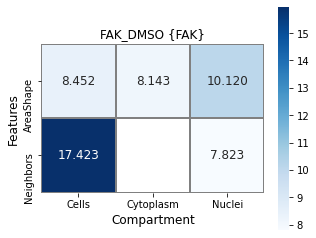

In [258]:

def Areashape_Neighbors_feature_grid(df, cellline, target_list, target):
    d = df.query('Metadata_cell_line in @ cellline and Metadata_Target in @ target_list')


    feat = [col for col in d.columns if not "Metadata" in col]

    featlist =  ['Metadata_compound_name'] + feat
    


    dn = (d.loc[:, featlist].groupby('Metadata_compound_name')
        .mean()
        .T
        .reset_index()
        .rename(columns={'index': "variables"})
        )


    dn['Compartment'] = np.where(dn.variables.str.contains("Cells"), 'Cells',
                                 np.where(dn.variables.str.contains("Nuclei"), 'Nuclei', 
                                 np.where(dn.variables.str.contains("Cytoplasm"), 'Cytoplasm', 'NA')))

    dn['Features'] = np.where(dn.variables.str.contains("AreaShape"), 'AreaShape',
                              np.where(dn.variables.str.contains("Neighbors"), 'Neighbors', 'NA'))


    dn = dn.query("Features != 'NA'")
    
#Taking mean absolute  z scores

    if target == "FAK":
        drug_samples = ['DMSO', 'PND-1186']
        dn = dn.assign(FAK_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']))
        
        
    elif target == "SECRET":
        drug_samples= ['DMSO', 'BSJ-04-030', 'BSJ-03-136']   
        dn = dn.assign(Active_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Inactive_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Active_Inactive = lambda x: abs(x[drug_samples[2]]) - abs(x[drug_samples[1]]))
        
    elif target == "PIN1":
        drug_samples=['DMSO', 'BJP-06-115-3', 'BJP-06-005-3']
        dn = dn.assign(Active_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Inactive_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Active_Inactive = lambda x: abs(x[drug_samples[2]]) - abs(x[drug_samples[1]]))
        
    elif target == "DCLK1":
        drug_samples= ['DMSO', 'FMF-03-146-1', 'FMF-04-112-1']
        dn = dn.assign(Active_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Inactive_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Active_Inactive = lambda x: abs(x[drug_samples[1]]) - abs(x[drug_samples[2]]))
        
    elif target== "CDK14_pan-TAIRE":
        drug_samples= ['DMSO', 'FMF-04-159-2', 'FMF-05-176-1']
        dn = dn.assign(Covalent_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Reversible_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Reversible_Covalent = lambda x: abs(x[drug_samples[2]]) - abs(x[drug_samples[1]]))
        
    elif target== "ERK5":
        drug_samples=['DMSO', 'JWG-071', 'AX15836', 'JWG-119']
        dn = dn.assign(JWG_active_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  AX_active_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  JWG_Inactive_DMSO = lambda x: abs(x[drug_samples[3]]) - abs(x['DMSO']),
                  JWG_active_AX_active = lambda x: abs(x[drug_samples[1]]) - abs(x[drug_samples[2]]),
                  JWG_active_JWG_Inactive = lambda x: abs(x[drug_samples[1]]) - abs(x[drug_samples[3]]),
                  AX_active_JWG_Inactive = lambda x: abs(x[drug_samples[2]]) - abs(x[drug_samples[3]]))


        
    def comparison(target):
        
        
        if target == 'FAK':
            complist = ['FAK_DMSO']
            return complist
        elif target == 'SECRET':
            complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
            return complist
        elif target == 'DCLK1':
            complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
            return complist
        elif target == 'PIN1':
            complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
            return complist
        elif target == 'PIN1':
            complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
            return complist
        elif target == 'CDK14_pan-TAIRE':
            complist = ['Covalent_DMSO', 'Reversible_DMSO', 'Reversible_Covalent']
            return complist
        elif target == 'ERK5':
            complist = ['JWG_active_DMSO', 'AX_active_DMSO', 'JWG_Inactive_DMSO', 
                    'JWG_active_AX_active', 'JWG_active_JWG_Inactive', 'AX_active_JWG_Inactive']
            return complist
        else:
            print("Invalid Target")

    complist=comparison(target)
    
    data = []
    
    
    for comp in complist:
        
        if operation == 'mean':
            
    
            tmp2 = (dn.groupby(['Features', 'Compartment'])[comp]
            .mean()
            .reset_index()
               )
    
            data.append(tmp2)
        
        elif operation == 'median':
            
    
            tmp2 = (dn.groupby(['Features', 'Compartment'])[comp]
            .median()
            .reset_index()
               )
    
            data.append(tmp2)
        
        elif operation == 'max':
            
    
            tmp2 = (dn.groupby(['Features', 'Compartment'])[comp]
            .max()
            .reset_index()
               )
    
            data.append(tmp2)
        
        
        elif operation == 'quantile':
            
            tmp2 = (dn.groupby(['Features', 'Compartment'])[comp]
            .quantile(value)
            .reset_index()
               )
    
            data.append(tmp2)
                 
         
               
            
            
    prf = pd.concat(data, axis=1)
      


    prf = prf.loc[:, ~prf.columns.duplicated()]
    
    ### calculating the min and 95th percentile value for the color scale bar in plotting for comparison
    
    min_value= prf[complist].min(axis=0).min()
    max_value= np.quantile(prf[complist].values, .95)
    
    for cmp in complist:
        
    
        tmp3 = prf.pivot('Features', 'Compartment')[cmp]

    ### Plotting
      
        plt.figure(figsize=(5,5))
        plt.xlabel('Compartment', size=12)
        plt.ylabel('Features', size=12)
        plt.title(str(cmp) + " {" + str(target) + "}", size=12)
        ax = sns.heatmap(tmp3, annot=True, fmt=".3f",annot_kws={"size": 12}, vmin = min_value, vmax = max_value,linewidths=1, linecolor="gray", square=True, cbar_kws={"shrink": .82}, cmap="Blues", cbar=True)
    
        fig = ax.get_figure()
 
    
        fig.savefig(str(outdirpath) + '/' + str(cmp) + "_" +  str(operation)+ "_" + str(variable_type) +'features_AreashapeNeighbors.png', bbox_inches="tight")
    
    
    return fig


prf = Areashape_Neighbors_feature_grid(data_std, cellline, target_list, target)

   









     

